In [1]:
import numpy.random as rand
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
%matplotlib inline

По условию $N_t-N_s$ независима с $N_s$, поэтому

$E(N_t-N_s|N_s) = E(N_t|N_S) - N_s = E(N_t-N_s)$, откуда

$E(N_t|N_S) = E(N_t-N_s) + N_s$

Известно, что

$N_t-N_s \sim Pois(\lambda(t-s))$, следовательно

$E(N_t-N_s) = \lambda(t-s)$, значит, окончательно имеем:

$E(N_t|N_S) = \lambda(t-s) + N_s$

In [2]:
# Получаем данные из файла

with open("6.csv") as file:
    index = 0
    data = []
    for line in file:
        if index == 0:
            poissonLambda =  1 / int(line[9:])
        elif index == 1:
            t0 = int(line[5:])
        elif index == 2:
            t = int(line[4:])
        else:
            data.append(float(line))
        index += 1

Считаем, что $\lambda$ - параметр экспоненциального закона. Сопряженным для экспоненциального распределением является $\Gamma(\alpha, \beta)$, возмем его в качестве априорного распределения. Апостреорное распределение в таком случае это $\Gamma(\alpha+n,\beta+\sum_{i=1}^{n}X_i)$. Байесовская оценка параметра $\lambda$ - $\frac{\alpha+n}{\beta+\sum_{i=1}^{n}X_i}$

Теперь убедимся, что оценки действительно оценивают $\lambda$.

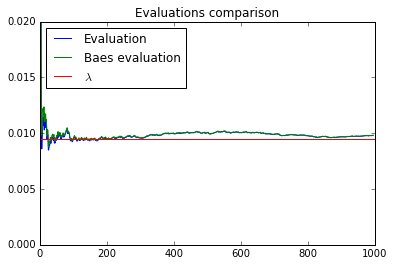

In [3]:
alpha, beta = 1, 1

xi = [data[i + 1] - data[i] for i in range(1, len(data) - 1)]

figure, axis = plt.subplots()
axis.plot(
    [1 / np.mean(xi[:n])
    for n in range(1, len(xi) - 1)],
    label=r"Evaluation"
)
axis.plot(
    [((alpha + len(xi[:n])) / (beta + np.sum(xi[:n])))
     for n in range(1, len(xi) - 1)],
    label=r"Baes evaluation"
)
axis.plot([0, 1000], [poissonLambda, poissonLambda], label=r"$\lambda$")
axis.legend(loc="upper left")
axis.set_ylim(0, 0.02)
axis.set_title("Evaluations comparison")

Подберем теперь более точные параметры априорного распределения. Для этого оценим параметр по нескольким первым знаениям и подгоним параметры априорного распределения под него.

In [21]:
N0 = 15 # Небольшое число по которому проведм первоначальную оценку lambda

startLambda = 1 / np.mean([data[i + 1] - data[i] for i in range(len(data) - 1)][:N0])
print(r"Начальная оценка: {}".format(startLambda))

Начальная оценка: 0.009243691627242836


По графику плотности видно, что взяв параметры $(x\lambda, x)$ можно добиться "горба" у плотности в точке $\lambda$. При этом, при увеличении $x$, уменьшается дисперсия распределения. Добьемся небольшого разброса $\lambda$.

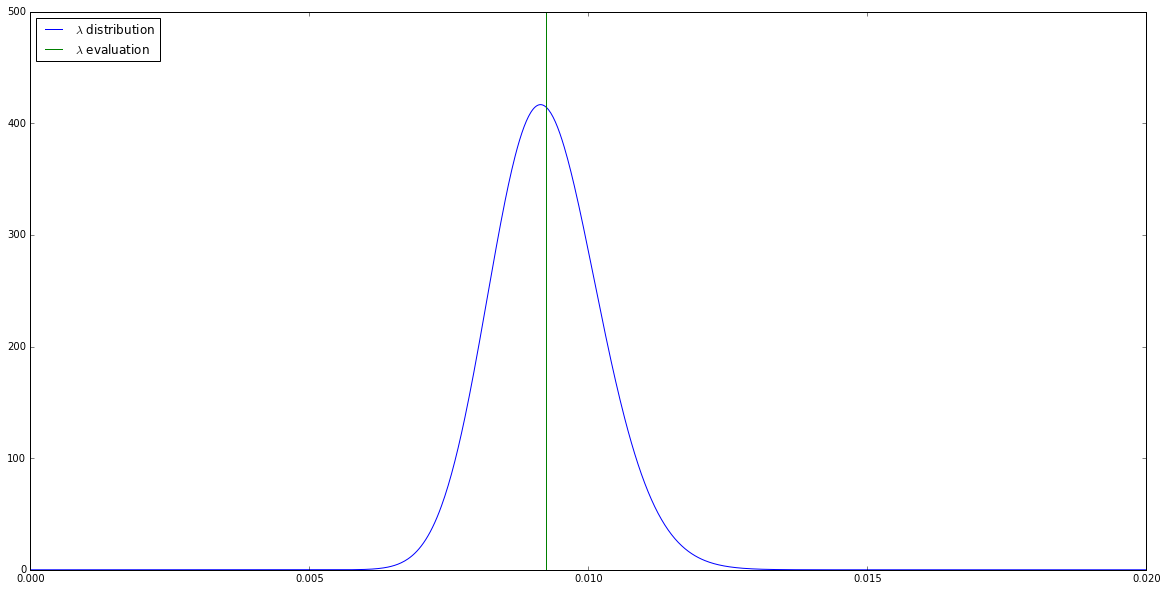

In [22]:
alpha, beta = 10000 * startLambda, 10000

x = np.linspace(0, 0.02, 1000)

figure = plt.figure(figsize=(20, 10))
axis = figure.add_subplot(1, 1, 1)
plt.plot(x, st.gamma.pdf(x, alpha, scale=1/beta), label="$\lambda$ distribution")
plt.plot([startLambda, startLambda], [0, 1000], label="$\lambda$ evaluation")
axis.set_ylim(0, 500)
axis.set_xlim(0, 0.02)
axis.legend(loc="upper left")
plt.show()

Теперь можно считать матожидание.

In [6]:
class Event:
    def __init__(self, type, time):
        self.type = type
        self.time = time

    def __lt__(self, other):
        return self.time < other.time

In [13]:
N = 205 # 205 значений k можно взять, пока мы не превысим t

events = [Event("break", value) for value in data] + [Event("timeout", k * t0) for k in range(N)]
events.sort()

In [19]:
xis, E, newE, poissonLambdas = [], [], [], []
lastXi = 0
k = 0
for event in events:
    if event.type == "break":
        xis.append(event.time - lastXi)
        lastXi = event.time
    else:
        k += 1
        newLambda = (alpha + len(xis)) / (beta + np.sum(xis))
        poissonLambdas.append(newLambda)
        E.append(poissonLambda * (t - k * t0) + len(xis))
        newE.append(newLambda * (t - k * t0) + len(xis))

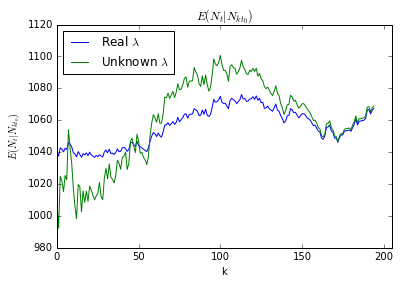

In [20]:
# Строим график

myFigure, myAxis = plt.subplots()
myAxis.plot (E[10:], label=r"Real $\lambda$")
myAxis.plot (newE[10:], label=r"Unknown $\lambda$")
myAxis.legend(loc="upper left")
myAxis.set_xlabel("k")
myAxis.set_ylabel(r"$E(N_t|N_{kt_0})$")
myAxis.set_xlim(0, N)
myAxis.set_title(r"$E(N_t|N_{kt_0})$")

По графику видно, что величины сопоставимы и коррелируют между собой. При больших $k$ они практически совпадают.